In [ ]:
pip install openturns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import openturns as ot
import openturns.viewer as otv
from matplotlib import pylab as plt
from openturns.usecases import ishigami_function
ot.Log.Show(ot.Log.NONE)

In [ ]:
def Objective_Function(X):
    X1,X2,X3,X4,X5,X6,X7,X8,X9,X10 = X[0]
    Y12 = X[1][0]
    Y21 = X[2]
    f = (Y12**0.25/100 - 5 + X3)**2 + (np.log(X1)/100 - np.sqrt(Y21))*10 - X2*X9/1000

    return [f]


In [ ]:
def coupling_c12(X):
    X1,X2,X3,X4,X5,X6,X7,X8,X9,X10 = X[0]
    Y21=X[1]

    C12 = 0.036*X1**0.758*X2**0.0035*(X3/(np.cos(X4) + 1.5)**2)*X5**0.006*X6**0.04*(100*X7/(np.cos(X4 + 1.5)**2))**(-0.3)*(X8*X9)**0.49 + X1*X10 + 10*Y21**(3/2) + np.sqrt(X8)/X6 + 20
    return [C12]

In [ ]:
def coupling_c21(X):
    X1,X3,X9 = X[0]
    Y12=X[1][0]

    C21 = 100*(X1**0.3 + X3**0.2)/X9**0.6*np.log(Y12/(Y12 + 100)) + 500 + 5*np.cos((Y12 + X1)**0.4)**2
    return[C21]

In [ ]:
def Gauss_Seidel(Z):
    zi = Z[0]
    zj = Z[1]
    y_ji = Z[2]
    delta_ref = Z[3]
    k_max = Z[4]
    k = 0
    y_ij = coupling_c12([zi,y_ji])
    y_ji_new = coupling_c21([zj,y_ij])
    delta = abs(y_ji_new[0] - y_ji)
    k += 1
    while delta > delta_ref and k<k_max:
        y_ji = y_ji_new[0]
        y_ij = coupling_c12([zi,y_ji])
        y_ji_new = coupling_c21([zj,y_ij])
        delta = abs(y_ji_new[0] - y_ji)
        k+=1
    if k<k_max:
        return([y_ji_new[0],y_ij,k])
    else:
        print("not converged")
        exit()

In [ ]:
def FPI(X):
    X1,X2,X3,X4,X5,X6,X7,X8,X9,X10 = X
    Y21 = 0
    Z_1 = [X1,X2,X3,X4,X5,X6,X7,X8,X9,X10]
    Z_2 = [X1,X3,X9]
    Y21,Y12,k = Gauss_Seidel([Z_1,Z_2,Y21, 0.01,10000])
    f_obj = Objective_Function([Z_1,Y12,Y21])
    return [f_obj[0]]

func=ot.PythonFunction(10,1,FPI)

In [ ]:
marginals = [ot.Uniform(150.0, 200.0),ot.Uniform(220.0,300.0),ot.Uniform(6.0,10.0),ot.Uniform(0.5,5.0),ot.Uniform(16.0,40.0),ot.Uniform(0.5,1.0),ot.Uniform(0.08,0.18),ot.Uniform(2.5,6.0),ot.Uniform(1700.0,2200.0),ot.Uniform(.025,0.08)]
distribution = ot.ComposedDistribution(marginals)

Samples = distribution.getSample(500) #500 échantillons de X,dim(X)=10

##No tresholding

In [ ]:
f_obj = []
for i in range(500):
  f_obj.append(func(Samples[i]))

f_obj = ot.Sample(np.array(f_obj).reshape(-1,1))

In [ ]:
covarianceModelCollection = []
for i in range(10):
    Xi = Samples.getMarginal(i)
    inputCovariance = ot.SquaredExponential(1)
    inputCovariance.setScale(Xi.computeStandardDeviation())
    covarianceModelCollection.append(inputCovariance)

In [ ]:
outputCovariance = ot.SquaredExponential(1)
outputCovariance.setScale(f_obj.computeStandardDeviation())
covarianceModelCollection.append(outputCovariance)

In [ ]:
estimatorType = ot.HSICUStat()

Calcul des HSIC pour ce modèle entre la liste des échantillons et l'output f_obj avec l'estimateur non-biaisé

In [ ]:
globHSIC = ot.HSICEstimatorGlobalSensitivity(covarianceModelCollection, Samples, f_obj, estimatorType)

In [ ]:
R2HSICIndices = globHSIC.getR2HSICIndices()
print("\n Global HSIC analysis")
print("R2-HSIC Indices: ", R2HSICIndices)


 Global HSIC analysis
R2-HSIC Indices:  [-0.00150001,0.447393,0.00238484,0.000120866,0.00140722,-0.0031683,-0.00185198,-0.00252054,0.247895,-0.000273073]#10


In [ ]:
HSICIndices = globHSIC.getHSICIndices()
print("HSIC Indices: ", HSICIndices)

HSIC Indices:  [-0.000134921,0.0404723,0.000208029,1.077e-05,0.00012563,-0.000286966,-0.0001704,-0.000225693,0.0218997,-2.44071e-05]#10


In [ ]:
pvas = globHSIC.getPValuesAsymptotic()
print("p-value (asymptotic): ", pvas)

p-value (asymptotic):  [0.65075,4.94116e-77,0.175002,0.397115,0.249579,0.926783,0.717266,0.829804,3.05154e-49,0.450542]#10


In [ ]:
pvperm = globHSIC.getPValuesPermutation()
print("p-value (permutation): ", pvperm)

p-value (permutation):  [0.673267,0,0.178218,0.366337,0.227723,0.950495,0.673267,0.871287,0,0.336634]#10


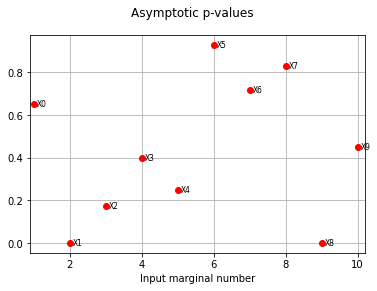

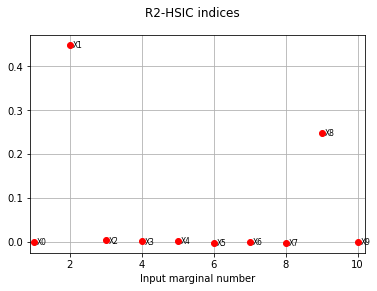

In [ ]:
graph2 = globHSIC.drawPValuesAsymptotic()
view2 = otv.View(graph2)

graph3 = globHSIC.drawR2HSICIndices()
view3 = otv.View(graph3)

**Remarque: Il faudra faire attention au seuil sur les p-value pour identifier les variables que l'on garde, ici un seuil à 0.1 (voir légérement au dessus) peu se justifier pour garder X2, X3, X4, X8 et X9 ...**

--------------------------------------------------------------------------------

#Zero Thresholding

--------------------------------------------------------------------------------

On trouve le quantile q_20 pour la liste F_obj

In [ ]:
q = f_obj.computeQuantilePerComponent(0.20)

**Remarque: voir la cellule suivante pour le thresholding, il faut pas relancer des calculs avec le FPI mais "juste" post-traiter les résultats obtenus**

In [ ]:
## Zero-thresholding
f_obj_arr = np.array(f_obj)

f_obj_tot = np.zeros((len(f_obj_arr),1))
for i in range(len(f_obj_tot)):
  if f_obj_arr[i]<q:
    f_obj_tot[i] = f_obj_arr[i]
  else:
    f_obj_tot[i] = 0.

f_obj_thresh = ot.Sample(f_obj_tot)
### HSIC Zero thresholding with Samples and f_obj_q

Et on calcule les HSIC (pas de filter function comme dans l'exemple)

In [ ]:
covarianceModelCollection = []
for i in range(10):
    Xi = Samples.getMarginal(i)
    inputCovariance = ot.SquaredExponential(1)
    inputCovariance.setScale(Xi.computeStandardDeviation())
    covarianceModelCollection.append(inputCovariance)

outputCovariance = ot.SquaredExponential(1)
outputCovariance.setScale(f_obj_thresh.computeStandardDeviation())
covarianceModelCollection.append(outputCovariance)

estimatorType = ot.HSICUStat()
globHSIC_thresh = ot.HSICEstimatorGlobalSensitivity(covarianceModelCollection, Samples, f_obj_thresh, estimatorType)

R2HSICIndices = globHSIC_thresh.getR2HSICIndices()
print("\n Global HSIC analysis")
print("R2-HSIC Indices: ", R2HSICIndices)

pvas = globHSIC_thresh.getPValuesAsymptotic()
print("p-value (asymptotic): ", pvas)


 Global HSIC analysis
R2-HSIC Indices:  [0.00196202,0.283657,-0.0020062,-0.00105914,-0.00254588,0.000801845,-0.000500167,-0.00263348,0.179214,-0.00206243]#10
p-value (asymptotic):  [0.183661,5.66554e-28,0.755538,0.539499,0.915226,0.274116,0.443973,0.948394,9.37867e-23,0.778796]#10


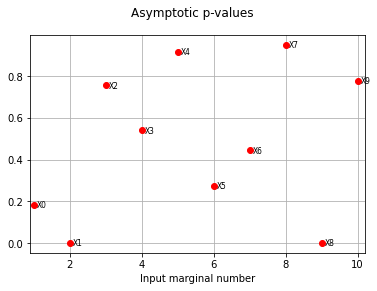

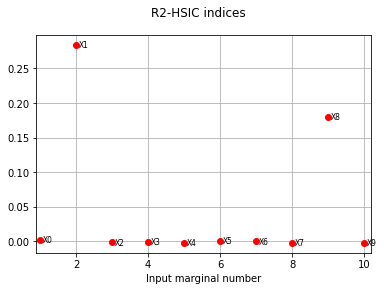

In [ ]:
graph2 = globHSIC_thresh.drawPValuesAsymptotic()
view2 = otv.View(graph2)

graph3 = globHSIC_thresh.drawR2HSICIndices()
view3 = otv.View(graph3)

--------------------------------------------------------------------------------

#Conditional Thresholding

--------------------------------------------------------------------------------
Pour le conditional thresholding, on sélectionne d'avance dans Samples

On ne garde que les échantillons qui sont dans D

In [ ]:
q = f_obj.computeQuantilePerComponent(0.2)

In [ ]:
f_obj_arr = np.array(f_obj)
## Conditional thresholding
mask = f_obj_arr<q
f_obj_q_arr = f_obj_arr[mask]

Samples_arr = np.array(Samples)
Samples_q_arr = Samples_arr[mask.squeeze(),:]
f_obj_cond = ot.Sample(f_obj_q_arr.reshape(-1,1))
Samples_cond = ot.Sample(Samples_q_arr)
print(f_obj_cond.getSize(),Samples_cond.getSize())
### HSIC with Conditional thresholding with Samples_q and f_obj_q

100 100


Et on recalcule les HSIC

In [ ]:
covarianceModelCollection = []
for i in range(10):
    Xi = Samples_cond.getMarginal(i)
    inputCovariance = ot.SquaredExponential(1)
    inputCovariance.setScale(Xi.computeStandardDeviation())
    covarianceModelCollection.append(inputCovariance)

outputCovariance = ot.SquaredExponential(1)
outputCovariance.setScale(f_obj_cond.computeStandardDeviation())
covarianceModelCollection.append(outputCovariance)

estimatorType = ot.HSICUStat()
globHSIC_cond = ot.HSICEstimatorGlobalSensitivity(covarianceModelCollection, Samples_cond, f_obj_cond, estimatorType)

R2HSICIndices = globHSIC_cond.getR2HSICIndices()      #HSIC "normalisé"
print("\n Global HSIC analysis")
print("R2-HSIC Indices: ", R2HSICIndices)

pvas = globHSIC_cond.getPValuesAsymptotic()
print("p-value (asymptotic): ", pvas)


 Global HSIC analysis
R2-HSIC Indices:  [0.0125282,0.178113,0.00544792,0.0309184,-0.0128672,-0.00748898,-0.0060356,-0.0103535,0.196352,0.0042824]#10
p-value (asymptotic):  [0.162902,2.81376e-09,0.276645,0.0242146,0.871917,0.664176,0.608263,0.764183,2.23538e-09,0.304819]#10


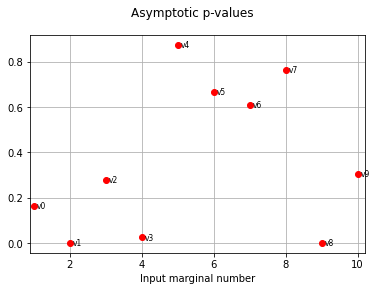

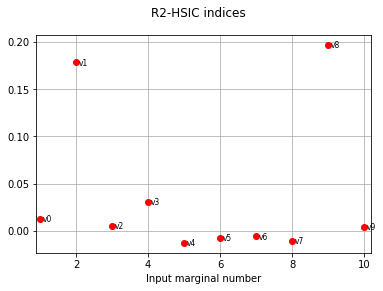

In [ ]:
graph2 = globHSIC_cond.drawPValuesAsymptotic()
view2 = otv.View(graph2)

graph3 = globHSIC_cond.drawR2HSICIndices()
view3 = otv.View(graph3)

--------------------------------------------------------------------------------

#Indicator Thresholding

--------------------------------------------------------------------------------

In [ ]:
## Indicator-thresholding
f_obj_arr = np.array(f_obj)

f_obj_tot = np.zeros((len(f_obj_arr),1))
for i in range(len(f_obj_tot)):
  if f_obj_arr[i]<q:
    f_obj_tot[i] = 1.
  else:
    f_obj_tot[i] = 0.

f_obj_q = ot.Sample(f_obj_tot)
### HSIC Indicator thresholding with Samples and f_obj_q

In [ ]:
covarianceModelCollection = []
for i in range(10):
    Xi = Samples.getMarginal(i)
    inputCovariance = ot.SquaredExponential(1)
    inputCovariance.setScale(Xi.computeStandardDeviation())
    covarianceModelCollection.append(inputCovariance)

outputCovariance = ot.SquaredExponential(1)
outputCovariance.setScale(f_obj_cond.computeStandardDeviation())
covarianceModelCollection.append(outputCovariance)

estimatorType = ot.HSICUStat()
globHSIC_ind = ot.HSICEstimatorGlobalSensitivity(covarianceModelCollection, Samples, f_obj_q, estimatorType)

R2HSICIndices = globHSIC_ind.getR2HSICIndices()      #HSIC "normalisé"
print("\n Global HSIC analysis")
print("R2-HSIC Indices: ", R2HSICIndices)

pvas = globHSIC_ind.getPValuesAsymptotic()
print("p-value (asymptotic): ", pvas)


 Global HSIC analysis
R2-HSIC Indices:  [0.00196215,0.283194,-0.00201772,-0.00108373,-0.00253393,0.000805677,-0.000506746,-0.00262534,0.17861,-0.00206383]#10
p-value (asymptotic):  [0.183351,6.32134e-28,0.759187,0.543534,0.913514,0.273259,0.444392,0.948505,1.0878e-22,0.779967]#10


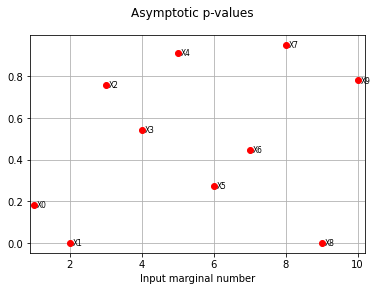

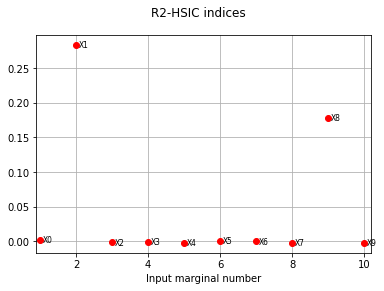

In [ ]:
graph2 = globHSIC_ind.drawPValuesAsymptotic()
view2 = otv.View(graph2)

graph3 = globHSIC_ind.drawR2HSICIndices()
view3 = otv.View(graph3)
